In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import optimizers
import keras.callbacks as callbacks

import numpy as np
import time
from sklearn import datasets
from sklearn import preprocessing

import theano
import matplotlib.pyplot as plt

%matplotlib inline


colors = ['r','b','c','g','k','m','y']

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


# Load Data

In [2]:
ds = datasets.load_iris()
data   = ds['data']
T = ds['target']
# Transform target to maximum sparse
target = -np.ones((data.shape[0], np.unique(T).shape[0]))
for icls, cls in enumerate(np.unique(T)):
    target[T == cls,icls] = 1
tgt_classes = T

## Training indexes

In [3]:
ntrn = 0.7

indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
n = int(ntrn * data.shape[0])
itrn = indexes[:n]
itst = indexes[n:]

## Preprocess data

# Neural Network

In [4]:
def one_hot(t, r=None):
    """
    given a tensor t of dimension d with integer values from range(r), return a
    new tensor of dimension d + 1 with values 0/1, where the last dimension
    gives a one-hot representation of the values in t.
    
    if r is not given, r is set to max(t) + 1
    """
    if r is None:
        r = theano.max(t) + 1
        
    ranges = theano.tensor.shape_padleft(theano.tensor.arange(r), t.ndim)
    return theano.tensor.eq(ranges, theano.tensor.shape_padright(t, 1))

def max_mask(t, axis):
    """
    given a tensor t and an axis, returns a mask tensor of the same size which is
    1 where the tensor has a maximum along the given axis, and 0 elsewhere.
    """
    a = theano.tensor.argmax(t, axis=axis)
    a_oh = one_hot(a, t.shape[axis])
    # we want the 'one hot' dimension in the same position as the axis over
    # which we took the argmax. This takes some dimshuffle trickery:
    reordered_dims = range(axis) + [a_oh.ndim - 1] + range(axis, a_oh.ndim - 1)
    return a_oh.dimshuffle(reordered_dims)

In [6]:
def f1score(target, output):   
    y_hat = max_mask(output, 1)
    y = max_mask(target, 1)
    
    tp = theano.tensor.eq(y, y_hat).sum()
    tot = theano.tensor.eq(y, y).sum()   
    fp = tot - theano.tensor.eq(y, y_hat).sum()  
    
    # Overall metrics
    precision = tp / theano.tensor.maximum(1., tp + fp)
    recall = tp / theano.tensor.maximum(1., tot)
    f1 = (2. * precision * recall /
          theano.tensor.maximum(1, precision + recall))
    
    return f1

In [7]:
ninit = 1
nhidden = 4
nepochs = 500
batch_size = itrn.shape[0] # number of events from training set per epoch

nn_optimezers = ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam']

nn_optimezers = ['SGD']

nn_model = {}
nn_trn = {}
nn_perf ={}

for alg in nn_optimezers:
    print 'Training with ', alg,
    start_time = time.time()
    nn_perf[alg] = 0.0
    for iinit in range(ninit):
        # Network structure
        model = Sequential()
        model.add(Dense(nhidden, input_dim=data.shape[1], init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(target.shape[1], init='uniform')) 
        model.add(Activation('tanh'))
        # Training algorithm
        if alg == 'SGD':
            opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        elif alg == 'RMSprop':
            opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08)
        elif alg == 'Adagrad':
            opt = optimizers.Adagrad(lr=0.01, epsilon=1e-08)
        elif alg == 'Adadelta':
            opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08)
        elif alg == 'Adam':
            opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        elif alg == 'Adamax':
            opt = optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        elif alg == 'Nadam':
            opt = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

        model.compile(loss='mean_squared_error', optimizer=opt ,metrics=['accuracy', f1score])
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                                verbose=0, mode='auto')
        init_trn_desc = model.fit(data[itrn], target[itrn], 
                                  nb_epoch=nepochs, 
                                  batch_size=batch_size,
                                  callbacks=[earlyStopping], 
                                  verbose=0,
                                  validation_data=(data[itst],target[itst]),
                                  shuffle=False)
        Chat = model.predict(data[itst])
        acc = (np.argmax(Chat,axis=1) == np.argmax(target[itst], axis=1)).sum() / float(Chat.shape[0])
        if nn_perf[alg] < acc:
            nn_perf[alg] = acc
            nn_model[alg] = model
            nn_trn[alg] = init_trn_desc
    print ' took %i s'%(time.time()-start_time)

Training with  SGD  took 2 s


/Users/ciodaro/.virtualenvs/ahdas/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


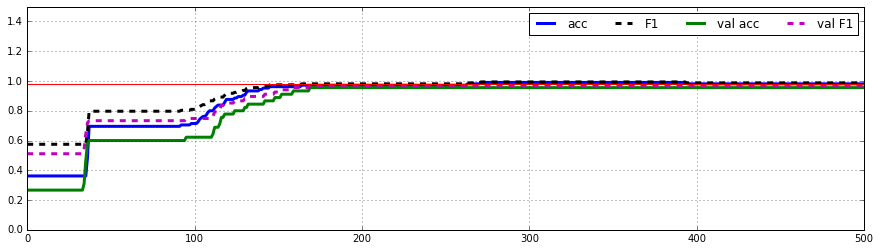

In [9]:
from sklearn.metrics import classification_report, recall_score
Chat = nn_model['SGD'].predict(data[itrn])
recall = recall_score(np.argmax(target[itrn], axis=1),np.argmax(Chat, axis=1))

plt.figure(figsize=(15,4))
for ialg, alg in enumerate(nn_optimezers):
    plt.plot(nn_trn[alg].epoch, nn_trn[alg].history['acc'], '-b', lw = 3, label='acc')
    plt.plot(nn_trn[alg].epoch, nn_trn[alg].history['f1score'],  '--k', lw = 3, label='F1')
    plt.plot(nn_trn[alg].epoch, nn_trn[alg].history['val_acc'], '-g', lw = 3, label='val acc')
    plt.plot(nn_trn[alg].epoch, nn_trn[alg].history['val_f1score'],  '--m', lw = 3, label='val F1')    
plt.ylim([0, plt.axis()[3]+0.5])
plt.plot([0,nn_trn[alg].epoch[-1]],[recall, recall],'-r')
plt.legend(loc='best', ncol=7)
plt.grid()

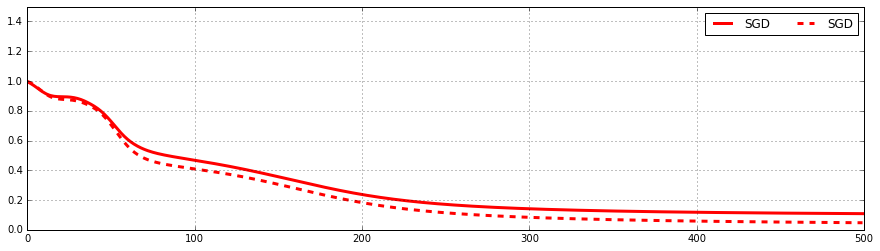

In [10]:
plt.figure(figsize=(15,4))
for ialg, alg in enumerate(nn_optimezers):
    plt.plot(nn_trn[alg].epoch, nn_trn[alg].history['val_loss'], '-',c=colors[ialg], lw = 3, label=alg)
    plt.plot(nn_trn[alg].epoch, nn_trn[alg].history['loss'], '--',c=colors[ialg], lw = 3, label=alg)    
plt.ylim([0, plt.axis()[3]+0.5])
plt.legend(loc='best', ncol=7)
plt.grid()

# Auto-encoder

In [23]:
lay = autoencoder.layers[2]
print lay.input_shape

(None, 4)


In [107]:
encoding_dim = 2
nhidden = 4
nepochs = 5000
batch_size = itrn.shape[0] # number of events from training set per epoch


# this is our input placeholder
input_layer = Input(shape=(data.shape[1],))
# "encoding" is the mapped representation in high dimension
mapping_layer = Dense(nhidden, activation='tanh')(input_layer)
# "compression" or "bottleneck" is the encoded representation of the input
encoding_layer = Dense(encoding_dim, activation='linear')(mapping_layer)
# "re-mapping" is the hyperdimension un-mapping
unmapping_layer = Dense(nhidden, activation='sigmoid')(encoding_layer)
# "re-mapping" is the hyperdimension un-mapping
decoding_layer = Dense(data.shape[1], activation='linear')(unmapping_layer)
# this model maps an input to its reconstruction
autoencoder = Model(input=input_layer, output=decoding_layer)

# Encoder model
encoder = Model(input=input_layer, output=encoding_layer)

# Training model
opt = optimizers.SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08)
opt = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-04, schedule_decay=0.009)


autoencoder.compile(optimizer=opt, loss='mean_squared_error')

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=200, verbose=0, mode='auto')
trn_desc = autoencoder.fit(data[itrn], data[itrn], 
                           nb_epoch=nepochs, 
                           batch_size=batch_size,
                           callbacks=[earlyStopping], 
                           verbose=0,
                           validation_data=(data[itst],data[itst]),
                           shuffle=True)


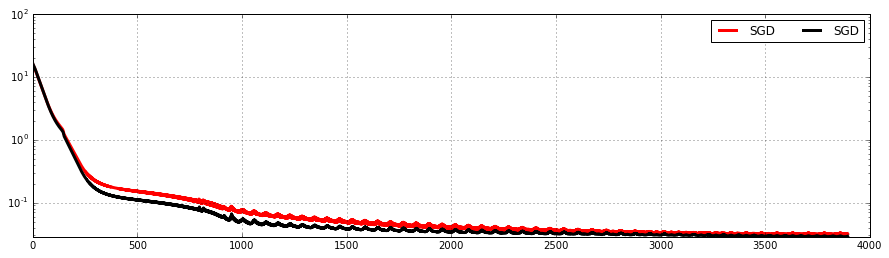

In [108]:
plt.figure(figsize=(15,4))
for ialg, alg in enumerate(nn_optimezers):
    plt.plot(trn_desc.epoch, trn_desc.history['val_loss'], '-' ,c=colors[ialg], lw = 3, label=alg)
    plt.plot(trn_desc.epoch, trn_desc.history['loss']    , '-k', lw = 3, label=alg)    
plt.yscale('log')
plt.ylim([0, plt.axis()[3]+0.5])
plt.legend(loc='best', ncol=7)

plt.grid()

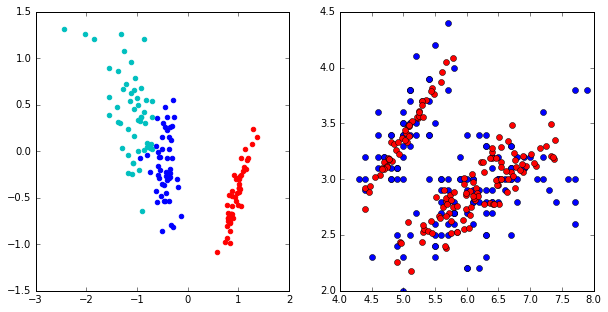

In [109]:
data_encoded = encoder.predict(data)
data_decoded = autoencoder.predict(data)


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for icls, cls in enumerate(np.unique(tgt_classes)):
    idx = tgt_classes == cls
    plt.scatter(data_encoded[idx,0], data_encoded[idx,1], color=colors[icls])

    
plt.subplot(1,2,2)
plt.plot(data[:,0], data[:,1],'o')
plt.plot(data_decoded[:,0], data_decoded[:,1],'or')